In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
%matplotlib inline

In [8]:
data = pd.read_csv('data.csv')

In [9]:
con=data['Month']
# convert to datetime timestamp
data['Month'] = pd.to_datetime(data['Month'])
# set date as the index of the dataframe
data.set_index('Month', inplace =True)

In [10]:
# double checking
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [11]:
#convert to time series data
ts = data['#Passengers']

In [12]:
#Functions
# Value at the specific time
ts['1949-01-01']

112

In [13]:
#Range of values between time 
ts['1940-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [14]:
#Range of values only with one index
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [15]:
#All rows of 1962
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [16]:
# It is important for a time series model to be Stationary . Which means all it's statistical properties (mean,variance) should be constant.
# This is because if we take and assume a behaviour in the past,it needs to be the same in the future as well.

In [17]:
# A series is stationary,if it haves
# constant mean
# constant variance
# An auto-covariance that doesn't depend on time

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


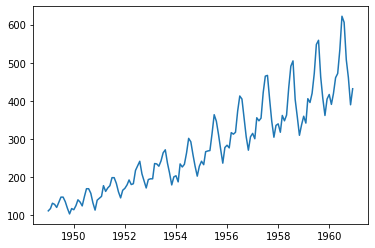

In [19]:
plt.plot(ts)

In [33]:
# Rolling mean and rolling standard deviation for 12 months
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [34]:
#Dickey-fuller Test :This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary (the force is strong with this one !!)

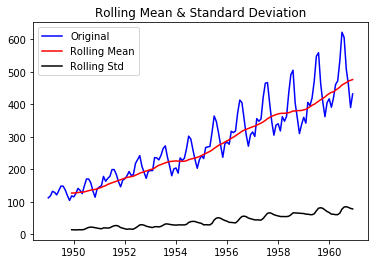

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [35]:
test_stationarity(ts)

In [37]:
# mean increases while standard deviation is almost the same - non-stationary
# By Dickey-Fuller Test , the test statistic is higher than crticial value - non-stationary
#Hence Non-stationary

In [38]:
# Make the time series data stationary
# A non-stationary is characterised by
# Trend:Non-constant mean
# Seasonality:Variation at specific time frames

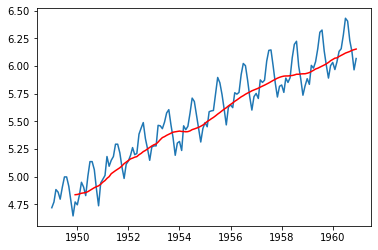

In [120]:
# The first step is to reduce the trend through transformation
# in this case we will logarithmic 

ts_log = np.log(ts)
# plt.plot(ts_log)

#model the trend
# Smoothing or
# Aggression  can be applied

# Smoothing:(moving average) or exponential moving average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color='red')

In [47]:
#subtract rolling mean/moving average  from the original series

ts_log_moving_average_difference = ts_log - moving_avg
ts_log_moving_average_difference.dropna(inplace = True)
ts_log_moving_average_difference.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

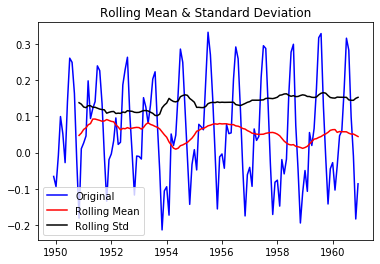

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [48]:
test_stationarity(ts_log_moving_average_difference)

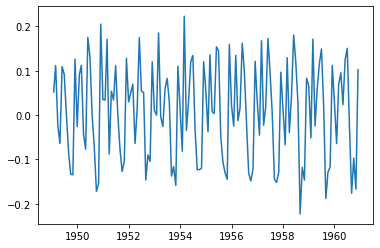

In [50]:
# The second step is to remove Seasonality along the Trend (Differecing(by taking difference using time lag) or decomposing(model both trend and seasonality, then remove the))

ts_log_Differencing = ts_log - ts_log.shift()
plt.plot(ts_log_Differencing)

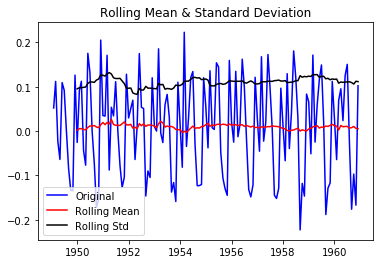

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [52]:
ts_log_Differencing.dropna(inplace=True)
test_stationarity(ts_log_Differencing)

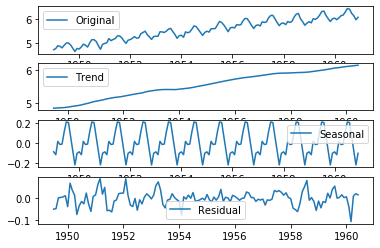

In [66]:
# Decomposing

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')

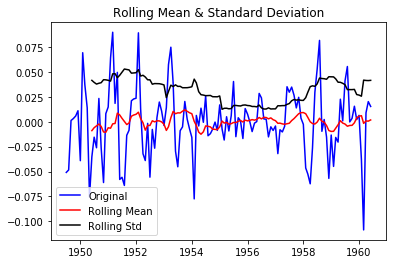

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [70]:
# Remove the trend and seasonality and use residuals
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [71]:
# now we have stationary data ,let's forcast a time series data
#ARIMA (Auto regressive integrated moving average)

# parameters
# p - Number of autoregressive terms
# q - Number of moving average terms
# d - Number of differences or non-seasonal differences


# To set these parameters we used two different functions
#ACF - Auto correlation function - measures the corelation between two different lagged versions
# example - At lag 4 ,it will compare time instance at t1 and t2 with t1 - lagged 4 and t2 -lagged 4
#Partial coorrelation function - measure the degree of association. between y(t) and y(t-p)

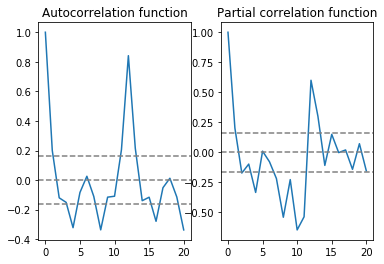

In [86]:
from statsmodels.tsa.arima_model import ARIMA
# ACF And PACF plots
from statsmodels.tsa.stattools import acf,pacf


lag_acf = acf(ts_log_Differencing, nlags=20)
lag_pacf = pacf(ts_log_Differencing, nlags=20, method='ols')

# plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.title('Autocorrelation function')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_Differencing)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_Differencing)), linestyle='--', color='gray')


# plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.title('Partial correlation function')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_Differencing)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_Differencing)), linestyle='--', color='gray')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

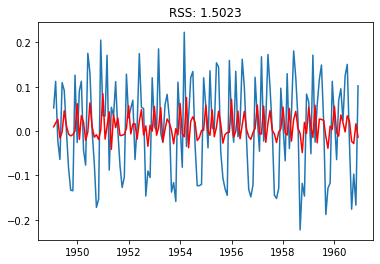

In [95]:
# PCF = 2 (p) and ACF = 2 (q)
# AR model ,moving average is 0
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp=1)
plt.plot(ts_log_Differencing)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_Differencing)**2))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

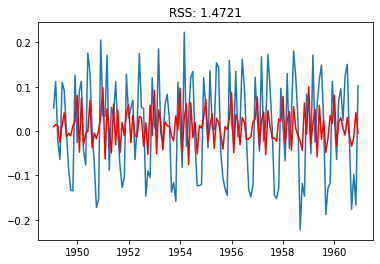

In [97]:
# PCF = 2 (p) and ACF = 2 (q)
# AR model ,moving average is 0
model = ARIMA(ts_log, order = (0,1,2))
results_MA = model.fit(disp=1)
plt.plot(ts_log_Differencing)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_Differencing)**2))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

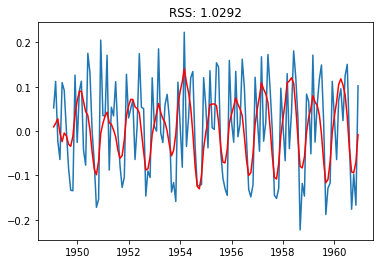

In [98]:
# ARIMA MODEL
model = ARIMA(ts_log, order = (2,1,2))
results_ARIMA = model.fit(disp=1)
plt.plot(ts_log_Differencing)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_Differencing)**2))

In [ ]:
# least is ARIMA and hence the best one

In [99]:
# Final step is to bring back to the original scale 

In [101]:
# get the predicted values and store it in a series
predictions_ARIMA_DIFF = pd.Series(results_ARIMA.fittedvalues, copy=True)

In [102]:
#convert differencing to log scale - intitaly differencing was done on the log scale - find cumsum and add it to new series
predictions_ARIMA_DIFF_cumsum = predictions_ARIMA_DIFF.cumsum()


In [106]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0],index = ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_DIFF_cumsum, fill_value = 0 )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'RMSE: 90.1047')

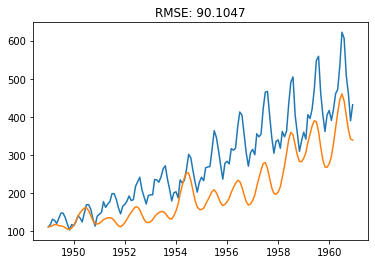

In [123]:
# take the exponential which is anti-log
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
# RMSE is 90